In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())


max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

데이터 확인

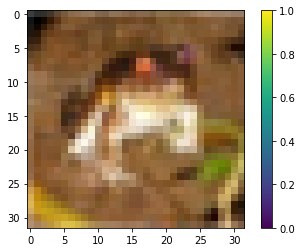

In [6]:
plt.imshow((train_x[0]+1)/2) # plt.imshow(train_x[0])으로 출력하려고 하니깐 안됨. train_x를 앞에서 [-1,1]범위로 정규화 했기 때문에 [0,1]범위로 만들어서 출력하면 된다.
plt.colorbar()
plt.show()

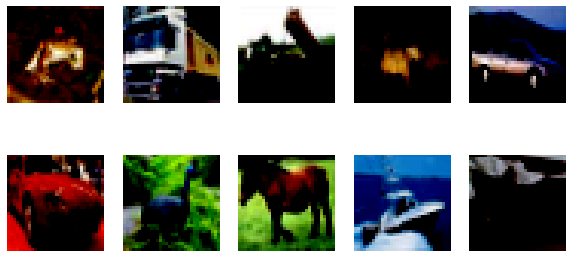

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(train_x[i])
  plt.axis('off')
plt.show()

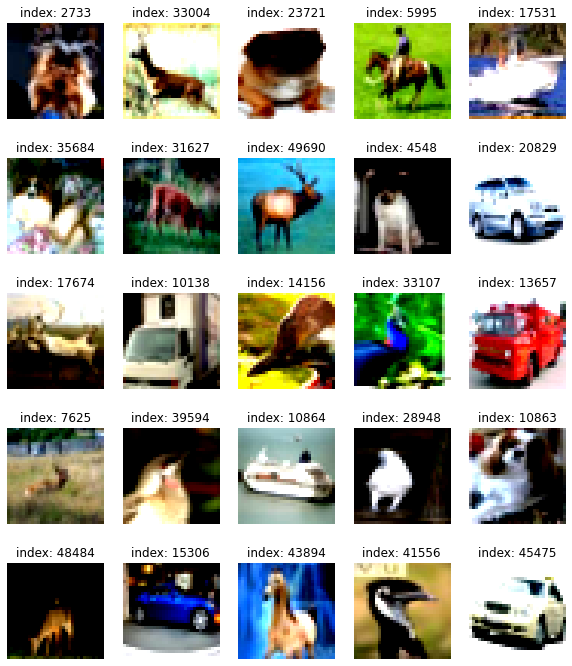

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
  plt.subplot(5, 5, i+1)
  np.random.seed(i)
  random_index = np.random.randint(1, 50000)
  plt.imshow(train_x[random_index]+1/2)
  plt.title(f'index: {random_index}')
  plt.axis('off')
plt.show()

plt.show()

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)>

# 생성자 구현하기

In [12]:
def make_generator_model():

  model = tf.keras.Sequential()

  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Reshape((8,8,256)))

  model.add(layers.Conv2DTranspose(512, kernel_size=(4,4), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
 
  model.add(layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
 
  model.add(layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2D(3, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  return model

In [13]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2097152   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

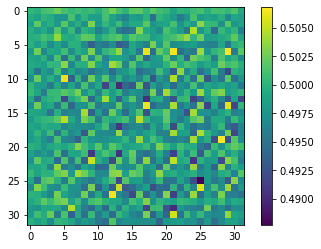

In [16]:
plt.imshow(generated_image[0,:,:,0]+1/2)
plt.colorbar()
plt.show()

# 판별자 모델 구현하기

In [17]:
def make_discriminator_model():
# Start
  model = tf.keras.Sequential()
# First: Conv2D Layer
  model.add(layers.Conv2D(128, (3,3), strides=(1,1), padding='same', input_shape=[32,32,3]))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))
# second: Conv2D Layer
  model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

# Third: Flatten Layer
  model.add(layers.Flatten())
# Fourth: Dense Layer
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  return model

In [18]:
# define model
discriminator = make_discriminator_model()
# summarize the model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)      

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50002855]], dtype=float32)>

# 손실함수와 최적화 함수 구하기

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_loss

In [21]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

discriminator_loss

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator accuracy



In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

optimizer(최적화 함수)


In [24]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5) # 모멘텀 
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계


In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    plt.savefig('/content/drive/MyDrive/Colab Notebooks/make_cifar_10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png')

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/make_cifar_10/training_history/train_history_{:04d}.png')
    plt.show()

In [29]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/make_cifar_10/training_checkpoints/'

checkpoint_prefix = (checkpoint_dir+'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 학습 과정 진행하기

In [30]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
          checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [35]:
save_every = 5
EPOCHS = 48

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

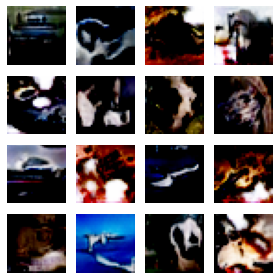

Epoch 49 | iter 51
Time for epoch 49 : 31 sec


KeyboardInterrupt: ignored

In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/make_cifar_10/gif/cifar10_dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/make_cifar_10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [34]:
anim_file = '/content/drive/MyDrive/Colab Notebooks/make_cifar_10/gif/cifar10_dcgan_1_history.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/make_cifar_10/training_history/train_history_1/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# 회고


우선 생각한 것보다 시간이 너무 오래 걸려서 당황스러웠다.  
기존의 노드에서 나왔던 대로 하니깐 결과가 엉망으로 나왔었다. 그래서 생성자와 판별자에서 층을 추가 하였고 전보다 향상된 결과가 나왔다.